<a href="https://colab.research.google.com/github/ahmedSadoun/colab-project/blob/main/vgg16_mnist_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 88.1MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 147MB/s]
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 99.8MB/s]


In [ ]:
import zipfile
zf='/content/test.csv.zip'
target_dir = "/content"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

zf='/content/train.csv.zip'
target_dir = "/content"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

In [ ]:
#dont forget to create manually two folders train and test inside content directory
import cv2
from tqdm import tqdm
df_train_processed = pd.DataFrame(columns=['id', 'label'])

ids = []
for i in tqdm(range(len(df_train))):
    img = df_train.iloc[i, 1:].values.reshape(28, 28 )
    img = cv2.imwrite('/content/train/{}.png'.format(i), img)
    ids.append('{}.png'.format(i))
df_train_processed['id'] = ids
df_train_processed['label'] = df_train['label'].astype(str)

100%|██████████| 42000/42000 [00:13<00:00, 3172.31it/s]


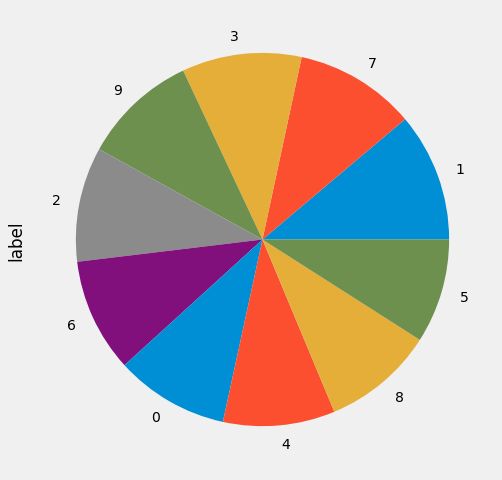

In [ ]:
plt.figure(figsize=(16, 8))
df_train_processed['label'].value_counts().plot(kind='pie')

In [ ]:
import cv2
from tqdm import tqdm
df_test_processed = pd.DataFrame(columns=['id', 'label'])

ids = []
for i in tqdm(range(len(df_test))):
    img = df_test.iloc[i, :].values.reshape(28, 28)
    img = cv2.imwrite('/content/test/{}.png'.format(i), img)
    ids.append('{}.png'.format(i))
df_test_processed['id'] = ids

100%|██████████| 28000/28000 [00:07<00:00, 3703.16it/s]


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2, horizontal_flip=False, height_shift_range=0.2, width_shift_range=0.1, rotation_range=5)
test_gen = ImageDataGenerator(rescale=1/255.) 
img_size = (224, 224)
batch_size = 32
train_data = train_gen.flow_from_dataframe(dataframe=df_train_processed,
                                               directory='/content/train',
                                               x_col='id',
                                               y_col='label',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               target_size=img_size, 
                                               subset='training',
                                                validate_filenames=True)
val_data = train_gen.flow_from_dataframe(dataframe=df_train_processed,
                                                  directory="/content/train",
                                                  x_col="id",
                                                  y_col="label",
                                                  batch_size=batch_size,
                                                  class_mode="categorical",    
                                                  target_size=img_size,
                                                  subset='validation',
                                                validate_filenames=True,
                                                 shuffle=False
                                                )
test_generator = test_gen.flow_from_dataframe(dataframe=df_test_processed,
                                                  directory = "/content/test",
                                                  x_col="id",
                                                  target_size=img_size,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None,
                                                validate_filenames=True)

Found 33600 validated image filenames belonging to 10 classes.
Found 8400 validated image filenames belonging to 10 classes.
Found 28000 validated image filenames.


In [ ]:
# Loading Model
from keras.applications import VGG16
from keras.models import Model
pretrained_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
pretrained_model.summary()


58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:

from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
# Freezing the layers
for layer in pretrained_model.layers[:15]:
    layer.trainable = False
for layer in pretrained_model.layers[15:]:
    layer.trainable = True
 
# Modification of pretrained model
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output
 
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
 
# Creating a new model
model = Model(pretrained_model.input, x)
 
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
 
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]
# Training model
n_training_samples = len(train_data)
n_validation_samples = len(val_data)

history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    validation_steps=n_validation_samples//batch_size,
    steps_per_epoch=n_training_samples//batch_size
    ,callbacks=callbacks_list
    )
model.save("/content/drive/MyDrive/vgg16_final_save.h5")

Epoch 1/30
32/32 [==============================] - 53s 476ms/step - loss: 0.6102 - accuracy: 0.6686 - val_loss: 0.3539 - val_accuracy: 0.9000
Epoch 2/30
32/32 [==============================] - 15s 461ms/step - loss: 0.3603 - accuracy: 0.8999 - val_loss: 0.3280 - val_accuracy: 0.9000
Epoch 3/30
32/32 [==============================] - 15s 460ms/step - loss: 0.3493 - accuracy: 0.8998 - val_loss: 0.3281 - val_accuracy: 0.9000
Epoch 4/30
32/32 [==============================] - 15s 459ms/step - loss: 0.3488 - accuracy: 0.9000 - val_loss: 0.3275 - val_accuracy: 0.9000
Epoch 5/30
32/32 [==============================] - 15s 461ms/step - loss: 0.3507 - accuracy: 0.9000 - val_loss: 0.3278 - val_accuracy: 0.9000
Epoch 6/30
32/32 [==============================] - 15s 461ms/step - loss: 0.3457 - accuracy: 0.9000 - val_loss: 0.3273 - val_accuracy: 0.9000
Epoch 7/30
32/32 [==============================] - 15s 463ms/step - loss: 0.3466 - accuracy: 0.8992 - val_loss: 0.3273 - val_accuracy: 0.9000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
